# Installing the necessary libraries



In [15]:
pip install mediapipe  hmmlearn

In [37]:
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt


#Keypoint Extraction

In [17]:

# Initialize MediaPipe Pose model
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Function to extract keypoints from the video
def extract_keypoints(video_path):
    cap = cv2.VideoCapture(video_path)
    keypoints_sequence = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(frame_rgb)

        if results.pose_landmarks:
            frame_keypoints = []
            for landmark in results.pose_landmarks.landmark:
                x = landmark.x
                y = landmark.y
                frame_keypoints.append([x, y])
            keypoints_sequence.append(frame_keypoints)
        else:
            keypoints_sequence.append(None)

    cap.release()
    return keypoints_sequence

#Calculating Temporal Features

###**a) Speed and Acceleration**

In [59]:
import numpy as np

def calculate_speed_and_acceleration_features(keypoints_sequence):
    """
    Calculates speed and acceleration features to determine if the movement is fast or slow.
    """
    keypoints_sequence = np.array(keypoints_sequence)
    # Calculate speed (distance moved by each joint between frames)
    speed = np.sqrt(np.sum(np.diff(keypoints_sequence, axis=0)**2, axis=-1))
    avg_speed = np.mean(speed)
    max_speed = np.max(speed)

    # Calculate acceleration (change in speed between frames)
    acceleration = np.diff(speed, axis=0)
    avg_acceleration = np.mean(acceleration)
    max_acceleration = np.max(acceleration)


    return {
        "avg_speed": avg_speed,
        "max_speed": max_speed,
        "avg_acceleration": avg_acceleration,
        "max_acceleration": max_acceleration
    }

In [60]:
def process_video(video_path):
    cap = cv2.VideoCapture(video_path)
    keypoints_sequence = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Extract keypoints from the current frame
        keypoints = extract_keypoints_from_frame(frame)
        if keypoints is not None:
            keypoints_sequence.append(keypoints)

    cap.release()
    return keypoints_sequence  # List of (33, 2) keypoints arrays, one per frame

def extract_keypoints_from_frame(frame):

    results = pose.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    if results.pose_landmarks:
        # Extract keypoint coordinates (x, y) and normalize them based on the image width and height
        height, width, _ = frame.shape
        keypoints = [(int(landmark.x * width), int(landmark.y * height)) for landmark in results.pose_landmarks.landmark]
        return np.array(keypoints)
    else:
        return None

In [61]:
def classify_movement_as_fast_or_slow(features, speed_threshold=3.0, acceleration_threshold=3.0):

    if features["avg_speed"] > speed_threshold or features["avg_acceleration"] > acceleration_threshold:
        return "Jathiswaram"
    else:
        return "Padham"

In [62]:

video_path = "/content/drive/MyDrive/Dataset/jathi/jathi3.mp4"
keypoints_sequence = process_video(video_path)

if keypoints_sequence:

    features = calculate_speed_and_acceleration_features(keypoints_sequence)

    classification = classify_movement_as_fast_or_slow(features)
    print(f"The movement in the video is classified as: {classification}")

    print("Average Speed:", features["avg_speed"])
    print("Maximum Speed:", features["max_speed"])
    print("Average Acceleration:", features["avg_acceleration"])
    print("Maximum Acceleration:", features["max_acceleration"])
else:
    print("No keypoints detected in the video.")

The movement in the video is classified as: Jathiswaram
Average Speed: 5.7822809044723
Maximum Speed: 133.3604139165742
Average Acceleration: 0.04461230430337556
Maximum Acceleration: 114.12502985490286


###b)**Shape time and Transition time**



In [31]:

# Function to calculate temporal features: shape time and transition time
def calculate_shape_and_transition_times(keypoints_sequence):
    shape_times = []
    transition_times = []

    prev_keypoints = None
    for i, keypoints in enumerate(keypoints_sequence):
        if keypoints is None:
            continue

        if prev_keypoints:
            # Calculate transition time based on change in position (Euclidean distance)
            transition_time = np.linalg.norm(np.array(keypoints) - np.array(prev_keypoints))
            transition_times.append(transition_time)

        # Shape time is the duration of time a shape remains constant

        shape_times.append(1)

        prev_keypoints = keypoints

    return np.array(shape_times), np.array(transition_times)


In [63]:

# Function to classify the movement based on temporal features
def classify_movement(shape_times, transition_times, shape_threshold=1.5, transition_threshold=1.0):
    avg_shape_time = np.mean(shape_times)
    avg_transition_time = np.mean(transition_times)

    if avg_shape_time < shape_threshold and avg_transition_time < transition_threshold:
        classification = "Jathiswaram"  # Fast-paced movement
    else:
        classification = "Padham"  # Slow-paced movement

    return classification

video_path = "/content/drive/MyDrive/Dataset/jathi/jathi3.mp4"
keypoints_sequence = extract_keypoints(video_path)
shape_times, transition_times = calculate_shape_and_transition_times(keypoints_sequence)

classification = classify_movement(shape_times, transition_times)
print(f"The movement in the video is classified as: {classification}")


The movement in the video is classified as: Jathiswaram


###**c) Feeding this to HMM**

In [41]:
#Function to prepare observations for HMM model
def prepare_observations(video_path):
    keypoints_sequence = extract_keypoints(video_path)
    speeds, accelerations = calculate_speed_and_acceleration_features(keypoints_sequence)

    # Combine speed and acceleration as features for the HMM
    features = np.vstack([speeds, accelerations]).T
    return features

# Function to train a Hidden Markov Model (HMM)
def train_hmm(training_data, n_states=2):
    model = hmm.GaussianHMM(n_components=n_states, covariance_type="full", n_iter=100)
    model.fit(training_data)
    return model

# Function to classify the movement based on the trained HMM
def classify_movement(model, features):
    predicted_states = model.predict(features)
    # Determine if the movement is more likely to be "fast" (Jathi) or "slow" (Padham)
    # For simplicity, we'll consider the majority of states
    majority_state = np.bincount(predicted_states).argmax()

    if majority_state == 0:
        return "Padham"  # Slow-paced movement
    else:
        return "Jathi"   # Fast-paced movement

# Train on labeled data
video_paths_jathi = ["/content/drive/MyDrive/Dataset/jathi/jathi2.mp4", "/content/drive/MyDrive/Dataset/jathi/jathi_2.mp4"]  # Replace with actual paths
video_paths_padham = ["/content/drive/MyDrive/Dataset/Padham/sample1.mp4","/content/drive/MyDrive/Dataset/Padham/fullsample20_part_320_353.mp4"]  # Replace with actual paths

training_data = []

# Extract features from Jathi (fast-paced) and Padham (slow-paced) videos
for video_path in video_paths_jathi + video_paths_padham:
    features = prepare_observations(video_path)
    training_data.append(features)

# Flatten the list of training data
training_data = np.concatenate(training_data, axis=0)

# Train HMM with the collected training data
model = train_hmm(training_data, n_states=2)

# Test classification on a new video
test_video_path = "/content/drive/MyDrive/Dataset/Padham/fullsample18_part_200_239.mp4"
test_features = prepare_observations(test_video_path)

# Classify the movement in the test video
classification = classify_movement(model, test_features)
print(f"The movement in the video is classified as: {classification}")

The movement in the video is classified as: Padham


In [42]:
import numpy as np
from hmmlearn import hmm

# Function to prepare observations for HMM model
def prepare_observations(video_path):
    keypoints_sequence = extract_keypoints(video_path)
    shape_times, transition_times = calculate_shape_and_transition_times(keypoints_sequence)

    # Ensure both shape_times and transition_times have the same length by trimming or padding
    max_length = max(len(shape_times), len(transition_times))
    shape_times = np.pad(shape_times, (0, max_length - len(shape_times)), 'constant')
    transition_times = np.pad(transition_times, (0, max_length - len(transition_times)), 'constant')

    # Combine shape_time and transition_time as features for the HMM
    features = np.vstack([shape_times, transition_times]).T
    return features

# Function to train a Hidden Markov Model (HMM)
def train_hmm(training_data, n_states=2):
    model = hmm.GaussianHMM(n_components=n_states, covariance_type="full", n_iter=100)
    model.fit(training_data)
    return model

# Function to classify the movement based on the trained HMM
def classify_movement(model, features):
    predicted_states = model.predict(features)
    # Determine if the movement is more likely to be "fast" (Jathi) or "slow" (Padham)
    # For simplicity, we'll consider the majority of states
    majority_state = np.bincount(predicted_states).argmax()

    if majority_state == 0:
        return "Padham"  # Slow-paced movement
    else:
        return "Jathiswaram"   # Fast-paced movement

# Train on labeled data
video_paths_jathi = ["/content/drive/MyDrive/Dataset/jathi/jathi2.mp4", "/content/drive/MyDrive/Dataset/jathi/jathi_2.mp4"]  # Replace with actual paths
video_paths_padham = ["/content/drive/MyDrive/Dataset/Padham/fullsample18_part_200_239.mp4", "/content/drive/MyDrive/Dataset/Padham/fullsample20_part_320_353.mp4"]  # Replace with actual paths

training_data = []

# Extract features from Jathi (fast-paced) and Padham (slow-paced) videos
for video_path in video_paths_jathi + video_paths_padham:
    features = prepare_observations(video_path)
    training_data.append(features)

# Flatten the list of training data
training_data = np.concatenate(training_data, axis=0)

# Train HMM with the collected training data
model = train_hmm(training_data, n_states=2)

# Test classification on a new video
test_video_path = "/content/drive/MyDrive/Dataset/Padham/sample1.mp4"
test_features = prepare_observations(test_video_path)

# Classify the movement in the test video
classification = classify_movement(model, test_features)
print(f"The movement in the video is classified as: {classification}")


The movement in the video is classified as: Padham


##**VISUALISATIONS**





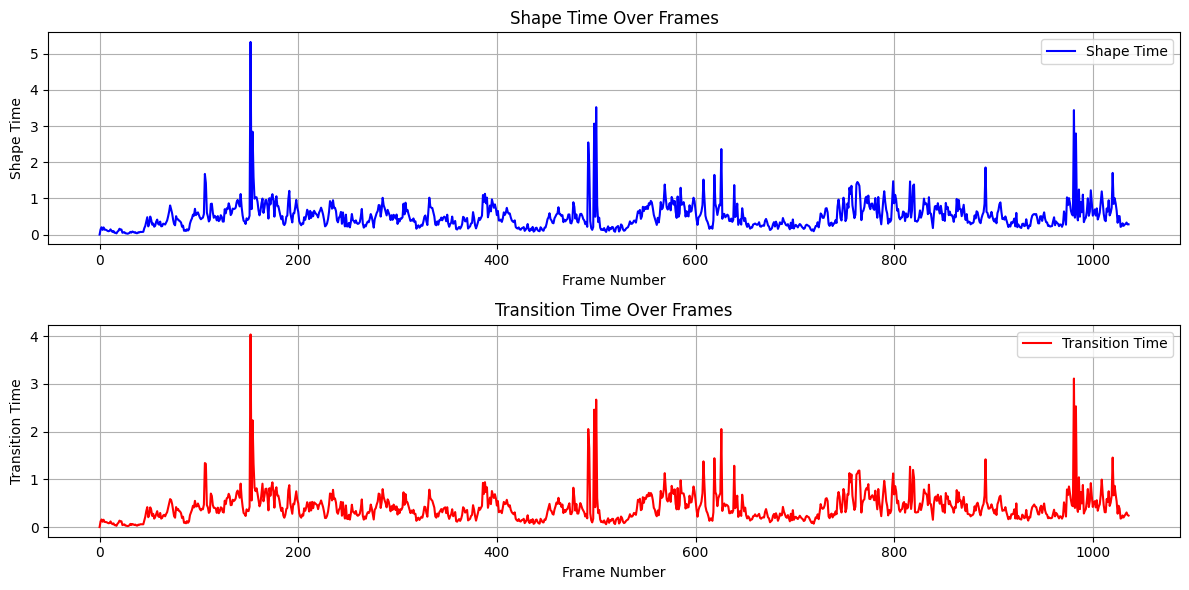

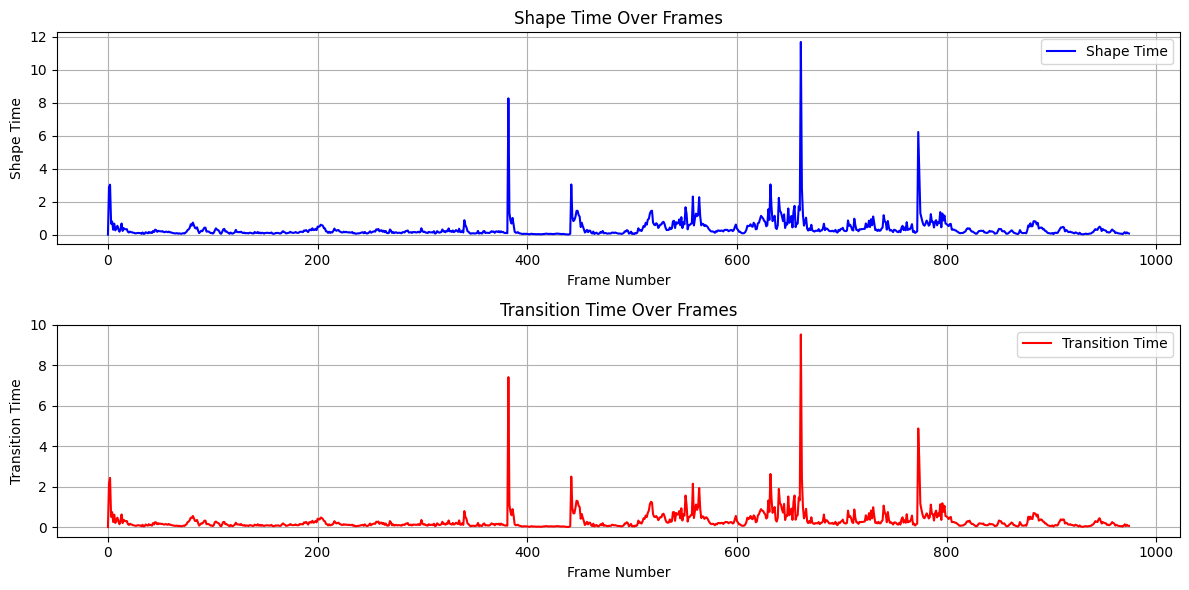

In [58]:

# Visualize the Shape and Transition Times
def visualize_shape_and_transition_times(video_path):
    keypoints_sequence = extract_keypoints(video_path)
    shape_times, transition_times = calculate_shape_and_transition_times(keypoints_sequence)

    # Plot Shape Time and Transition Time over frames
    frames = np.arange(len(shape_times))

    plt.figure(figsize=(12, 6))

    # Plot Shape Time
    plt.subplot(2, 1, 1)
    plt.plot(frames, shape_times, label="Shape Time", color="blue")
    plt.title("Shape Time Over Frames")
    plt.xlabel("Frame Number")
    plt.ylabel("Shape Time")
    plt.grid(True)
    plt.legend()

    # Plot Transition Time
    plt.subplot(2, 1, 2)
    plt.plot(frames, transition_times, label="Transition Time", color="red")
    plt.title("Transition Time Over Frames")
    plt.xlabel("Frame Number")
    plt.ylabel("Transition Time")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

test_video_path = "/content/drive/MyDrive/Dataset/jathi/jathi2.mp4"

test_video_path1 = "/content/drive/MyDrive/Dataset/Padham/fullsample18_part_200_239.mp4"
visualize_shape_and_transition_times(test_video_path)
visualize_shape_and_transition_times(test_video_path1)




If the movement in the video is fast-paced (like Jathi), you will likely observe larger peaks and fluctuations in both the Shape Time and Transition Time. These peaks correspond to rapid and large changes in body pose and movement.

If the movement is slow-paced (like Padham), the Shape Time and Transition Time will likely be smaller and more stable, with fewer sudden spikes.

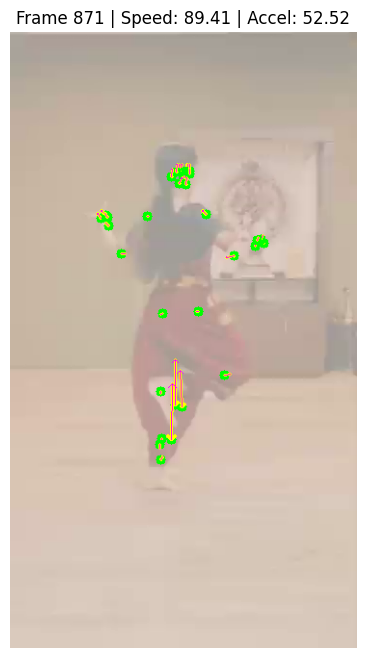

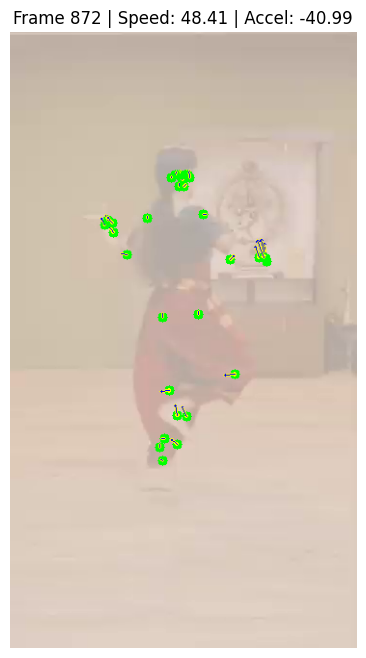

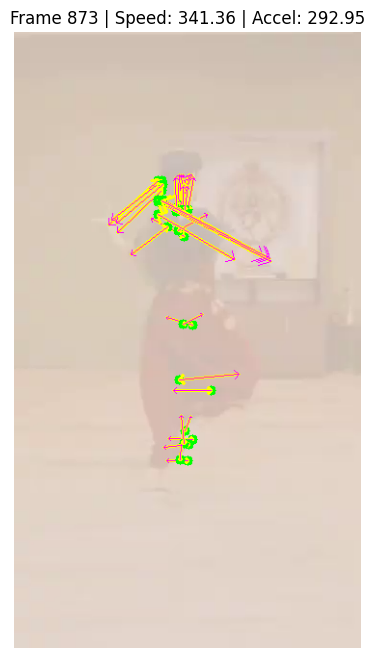

In [51]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_max_speed_and_acceleration(video_path):
    cap = cv2.VideoCapture(video_path)
    keypoints_sequence = []
    frames = []

    # Extract frames and keypoints
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        keypoints = extract_keypoints_for_frame(frame)  # Ensure this function is defined
        keypoints_sequence.append(keypoints)
        frames.append(frame)

    cap.release()

    # Calculate speed and acceleration
    speeds, accelerations = calculate_speed_and_acceleration_between_frames(keypoints_sequence)

    # Find indices of maximum speed and acceleration
    max_speed_idx = np.argmax(speeds)
    max_acceleration_idx = np.argmax(accelerations)

    # Select unique frames around these events
    selected_indices = set(
        [max_speed_idx - 1, max_speed_idx, max_speed_idx + 1, max_acceleration_idx]
    )
    selected_indices = sorted([idx for idx in selected_indices if 0 <= idx < len(frames)])

    # Visualize selected frames
    for idx in selected_indices:
        frame = frames[idx].copy()

        # Overlay keypoints and arrows
        if keypoints_sequence[idx] is not None:
            for i, (x, y) in enumerate(keypoints_sequence[idx]):
                # Draw keypoints
                cv2.circle(frame, (int(x), int(y)), 5, (0, 255, 0), -1)

                # Draw arrows showing speed/acceleration change
                if idx > 0 and keypoints_sequence[idx - 1] is not None:
                    prev_x, prev_y = keypoints_sequence[idx - 1][i]
                    speed_color = (0, min(int(speeds[idx - 1] * 10), 255), 255)
                    accel_color = (255, 0, min(int(accelerations[idx - 1] * 10), 255))

                    # Speed arrow (blue-green)
                    cv2.arrowedLine(
                        frame,
                        (int(prev_x), int(prev_y)),
                        (int(x), int(y)),
                        speed_color,
                        2,
                    )

                    # Acceleration arrow (red)
                    cv2.arrowedLine(
                        frame,
                        (int(x), int(y)),
                        (int(prev_x), int(prev_y)),
                        accel_color,
                        1,
                    )

        # Plot the frame
        plt.figure(figsize=(8, 8))
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.title(
            f"Frame {idx} | Speed: {speeds[idx-1]:.2f} | Accel: {accelerations[idx-1]:.2f}"
            if idx > 0
            else f"Frame {idx}"
        )
        plt.axis("off")
        plt.show()


# Video path
video_path = "/content/drive/MyDrive/Dataset/jathi/jathi3.mp4"

# Visualize max speed and acceleration frames
visualize_max_speed_and_acceleration(video_path)
